## Calculate burst-glide statistics and lower-frequency speed changes for each fish in a trial

### Using speed data for each fish:
   - identify time windows without tracking errors/gaps
   - identify burst timing and features (max speed, peak-valley amplitude, rise time, fall time, potentially fit parameters)
   - get sliding burst rate and smoothed speed over time for analyzing speed crosscorrelation in lower frequencies
    

In [1]:
#import needed modules
import numpy as np
import matplotlib.pyplot as plt
import pickle
import pandas as pd  
from scipy.io import loadmat
import glob
import get_kinematics_adult as kin

In [2]:
# define directories and import list of lines
datadir = '../data/'
resultdir = 'savedresults/'

[treatments] = pickle.load(open(resultdir+'treatmentlist.pkl','rb'))
treatments = np.array(treatments)
numtreatments = len(treatments)
[focustreatments,notfocus] = pickle.load(open(resultdir+'focustreatmentlist.pkl','rb'))
[allnumtrials] = pickle.load(open(resultdir+'allnumtrials.pkl','rb'))

pxpercm = 4.02361434 * 10  # from tracker
dt=1/60

In [3]:
#import single line
tnum = 0  # select which line, 0 = WT
treatment = treatments[tnum]
numtrials = allnumtrials[tnum]
[trial_speeds,trial_trajectories,trial_headings,trial_theta,
            trial_smoothspeeds,trial_smoothtrajectories,trial_smoothheadings,
            trial_ellipses,trial_arena,trial_sex,
            datafiles,trial_trackingerrors] = pickle.load(open(datadir+treatment+'-alltrials.pkl','rb'))

In [4]:
#load fishpair distances from file
filename = datadir+treatment+'-dcoords+dist-heading.pkl'
[trial_dcoords,trial_dist] = pickle.load(open(filename,'rb'))

In [5]:
#select single trial for line and fish to include in analysis 
#define speed, position, & orientatino for current trial 
#(to do: set up to iterate through all trials & save relevant data)
trialnum = 8
fishIncl = np.arange(6) #maybe unecessary
nframes = trial_trajectories[trialnum].shape[0]
speeds = trial_speeds[trialnum].copy()
positions = trial_trajectories[trialnum].copy()
ori = trial_headings[trialnum].copy()

## Identify frames with bad data for each fish

In [6]:
#initialize badData dataframe; types: nan, flatspeed, doubleID (note which), other
errType = pd.DataFrame(np.zeros([nframes,fishIncl.size], dtype=int), columns = ['fish0','fish1','fish2','fish3','fish4','fish5'])
errType.index.name = 'frame'
errType.head()
errCode = {0: 'noError',
 1: 'missing',
 2: 'flatSpeed',
 30: 'doubleID_0',
 31: 'doubleID_1',
 32: 'doubleID_2',
 33: 'doubleID_3',
 34: 'doubleID_4',
 35: 'doubleID_5'}

In [7]:
#add nans/missing data to errType
errs = trial_trackingerrors[trialnum][:,fishIncl].copy()
errType[errs] = 1

In [8]:
#find flatspeed for each fish - speed does not change (or change < threshold); define as baddata
#currently doing for single frames, consider adding time threshold

accel = np.gradient(speeds,axis=0)
accel[1:] = speeds[1:]-speeds[0:-1]
accel[np.isnan(accel)] = 1.0 #set nans to real value > threshold
errs = (np.abs(accel)<0.001)
errType[errs] = 2

#to do: add time thresold for this, I think it's catching things it doesn't need to

In [9]:
#add additional nans (not included in trackingerrors, not sure why)
errs = np.isnan(speeds)
errType[errs] = 1 #may change to another code, but for now treating all gaps the same way

In [10]:
#define baddata for at least one fish in pair when [dist,oridiff] < threshold (doubleID error)

#for each fishpair, each time point, get distance (trial_dist from file) and orientation diff (subtr heading)
dthresh = pxpercm #1 cm, ~40 pixels; same threshold used in paper; I may use looser threshold
othresh = .2 #taken from paper

for i in fishIncl:
    col0 = errType.columns[i]
    errcode1 = 30 + i
    for j in range(i+1,fishIncl.size):
        col1 = errType.columns[j]
        errcode0 = 30 +j
        dpair = trial_dist[trialnum][:,i,j].copy() 
        dpair[np.isnan(dpair)] = 100 #set nans to high values to avoid invalid values and false errID
        oridiff = trial_headings[trialnum][:,i]-trial_headings[trialnum][:,j]
        oridiff[np.isnan(oridiff)] = 6 #set nans to high values to avoid invalid values and false errID
        indErr = (abs(oridiff) < othresh) & (dpair < dthresh)
        errType.loc[indErr,col0] = errcode0
        errType.loc[indErr,col1] = errcode1

## Restore speed and position for nans during bursts 
- These were filtered by acceleration filter in original data processing, which was needed to remove tracking "jumps"
- Filtering by gap duration and the speed change makes it possible to determine which of these are likely bursts and add the data back
- Note: I'm only doing this locally for now, not resaving the pickle; may consider running through for everything and then saving if (1) it takes a long time and (2) I'm comfortable that I've validated the process well

In [11]:
groupdatadir = datadir + 'raw/' 
datafiles = np.sort([str.split(s,'/')[-1] for s in glob.glob(groupdatadir+ treatment +'/*mat')])

#open datafile (one for now, set to iterate through after tests); get trajectories, speed, heading
data = loadmat(groupdatadir + datafiles[trialnum])
def loadval(dictval):
    return np.array([t[0][0] for t in (np.array(data['trx'][dictval]).T)]) 
data_x = loadval('x')
data_y = loadval('y')
trajectories_raw = np.array([data_x,data_y]).T
velocities = np.gradient(trajectories_raw,axis=0)/dt #if these are too slow, could do just for regions of interest
speeds_raw = np.sqrt(velocities[:,:,0]**2 + velocities[:,:,1]**2) 
headings_raw = np.arctan2(velocities[:,:,1],velocities[:,:,0]) 

#define thresholds for potential burst-gaps (time < some duration, speed change > some amount)
errchanges = errType.diff()
timeTH = 25 #preliminary guess for threshold
speedTH = 500 #preliminary guess for threshold - seems to catch most, and spot checks on smaller burst-gaps look like they have clear errors in the raw speeds (e.g. step changes)
errcode = 8

for fish in fishIncl:   
    #find regions of interest: criteria: NaN value, duration < fthresh, speedmax - speedmin > speedTH
    aux = (errType.iloc[:,[fish]] == 1) & (errchanges.iloc[:,[fish]] == 1)
    indstart = np.flatnonzero(aux.values)-1
    aux = (errType.iloc[:,[fish]] == 0) & (errchanges.iloc[:,[fish]] == -1)
    indend = np.flatnonzero(aux.values)
    #remove cases where indstart and indend do not line up
    aux = np.ones(indstart.size, dtype = bool)
    for i in range(indstart.size-1):
        if ~np.any((indend > indstart[i]) & (indend <= indstart[i+1])):
            aux[i] = False
    indstart = indstart[aux]
    indstart.size
    aux = np.ones(indend.size, dtype = bool)
    for i in range(1,indend.size):
        if ~np.any((indstart < indend[i]) & (indstart >= indend[i-1])):
            aux[i] = 0
    indend = indend[aux]
    if indstart[-1] > indend[-1]:
        indstart = indstart[:-1]
    if indstart[0] > indend[0]:
        indend = indend[1:]
    
    #filter for possible bursts
    gapdata = np.vstack([indend-indstart,speeds[indend,fish]-speeds[indstart,fish]]).T
    burstgap = np.where((gapdata[:,0] < timeTH) & (gapdata[:,1] > speedTH))[0] #possible excluded bursts
    
    #replace speed, trajectory, and heading with raw data for putative excluded bursts
    for gap in burstgap:
        errType.iloc[indstart[gap]:indend[gap],[fish]] = errcode #assign new errortype for timewindow, to keep track of (may remove later)
        positions[indstart[gap]:indend[gap],fish] = trajectories_raw[indstart[gap]:indend[gap],fish]  
        ori[indstart[gap]:indend[gap],fish] = headings_raw[indstart[gap]:indend[gap],fish]
        speeds[indstart[gap]:indend[gap],fish] = speeds_raw[indstart[gap]:indend[gap],fish] 

#??resave pickle? or new pickle? not doing currently, but may add later if this is too slow to repeat each time

In [12]:
# # plots to validate errtypes, burstgap fixes, overall data quality
# fish = 0
# minframe= 11200
# duration = 800
# maxframe = minframe + duration
# xx = positions[minframe:maxframe,fish,0]
# yy = positions[minframe:maxframe,fish,1]
# # for orientations, best to use 'smoothheadings'
# orientations = ori[minframe:maxframe,fish]
# spd = speeds[minframe:maxframe,fish]
# errs = errType.iloc[minframe:maxframe,[fish]]

# # plot orientation and speed, and (opt) nan values
# f,ax=plt.subplots(3,1,sharex=True)
# f.set_size_inches(14,10)
# a = ax[0]
# a.plot(np.arange(minframe,maxframe),spd)
# a.set_ylim([0,1800])
# a.set_title('Speed')
# a = ax[1]
# a.plot(np.arange(minframe,maxframe),orientations)
# a.set_title('Orientation')
# a = ax[2]
# a.plot(np.arange(minframe,maxframe),errs)
# a.set_title('ErrorType')

# # a = ax[6]
# # a.plot(np.isnan(speeds))
# # a.set_title('NaN values')
# # plt.show()


## Find bursts in speed trajectory

   - Build on get_kinematics function for getting BGCycle
   - Tweak parameters for burst detection (especially nback)
   - Maybe: try w both smoothed and raw trajectories, see which is better
   - Either only do for good trajectories, or note when burst is baddata

In [13]:
# time = np.arange(nframes)*dt
# burstmat, burstrate = kin.getBGcycle(speeds[:,1], time = time, nbins = 2, threshold = 250.0, burstHtthresh = 100.0, exclnans = True) 
# burstmat.set_index('n',inplace = True)

In [14]:
#oriAligned = kin.getTurns(ori[fish],bursts,time) #needs to be adapted
#timeInactive = kin.getSwimTime(speed,time) #need to adapt for nans, maybe other

In [15]:
# #plots to check burst detection

# # for testing/debug
# f0, axs = plt.subplots(6,1, figsize=(16,24))

# nplots = 6
# timestart = 4000
# twinsize = 500 #
# twinstarts = np.arange(timestart, timestart + twinsize*nplots,twinsize) 

# for i in range(nplots):
#     twinstart = twinstarts[i]
#     twinend = twinstart+twinsize
#     ind = np.arange(twinstart,twinsize+twinstart)
#     axs[i].plot(time[ind], speeds[ind,1])
#     axs[i].set_title('Fish Speed')
#     axs[i].set_ylim([0,2200])

#     bstart = burstmat.loc[(burstmat['valleyTime'] > time[twinstart]) & (burstmat['valleyTime'] < time[twinend]),['valleyTime']].values
#     bpeak = burstmat.loc[(burstmat['valleyTime'] > time[twinstart]) & (burstmat['valleyTime'] < time[twinend]),['peakTime']].values
#     bb = np.hstack([bstart,bpeak])

#     #plot speed vs time or counter
#     for xc in bb:
#         axs[i].axvline(x = xc[0],color='deepskyblue')
#         axs[i].axvline(x = xc[1],color='mediumseagreen')


In [16]:
time = np.arange(nframes)*dt
fishnames = ['fish0','fish1','fish2', 'fish3', 'fish4','fish5']

bblist = []
bratelist = []
for fish in fishIncl:
    print(fish)
    bb, bbrate = kin.getBGcycle(speeds[:,fish], time = time, nbins = 2, threshold = 250.0, burstHtthresh = 100.0, exclnans = True) 
    bb.set_index('n',inplace = True)
    bblist.append(bb.copy())
    bratelist.append(bbrate.copy())    

0


C:\Users\katic\Anaconda3\lib\site-packages\scipy\optimize\minpack.py:795: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)
C:\Users\katic\OneDrive\Documents\MPI\zfish_genetics\kc_timing\zfish_mutants_analysis_KC\get_kinematics_adult.py:267: RuntimeWarning: overflow encountered in multiply
  return a*np.exp(-c*x)+d


1
2
3
4
5


In [17]:
burstsAll = pd.concat(bblist, keys = fishnames)
bRateAll = pd.concat(bratelist, keys = fishnames)

## generate basic plots for each fish

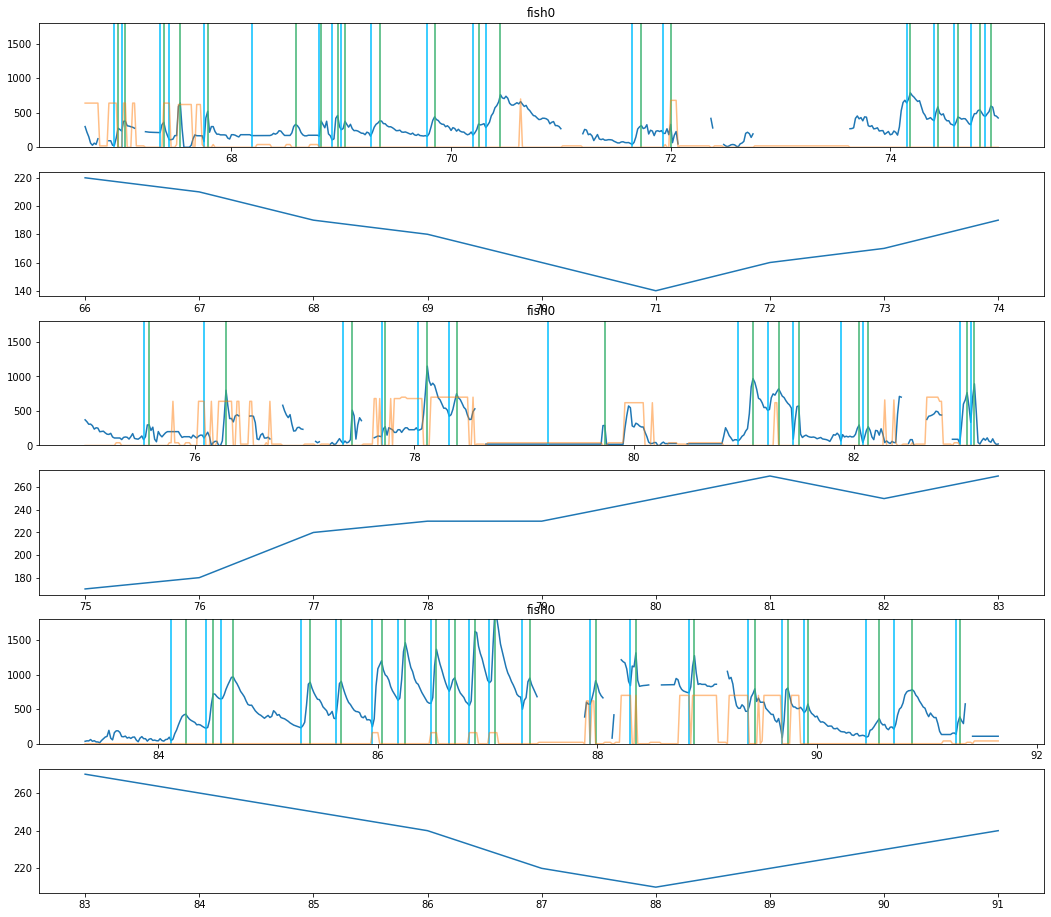

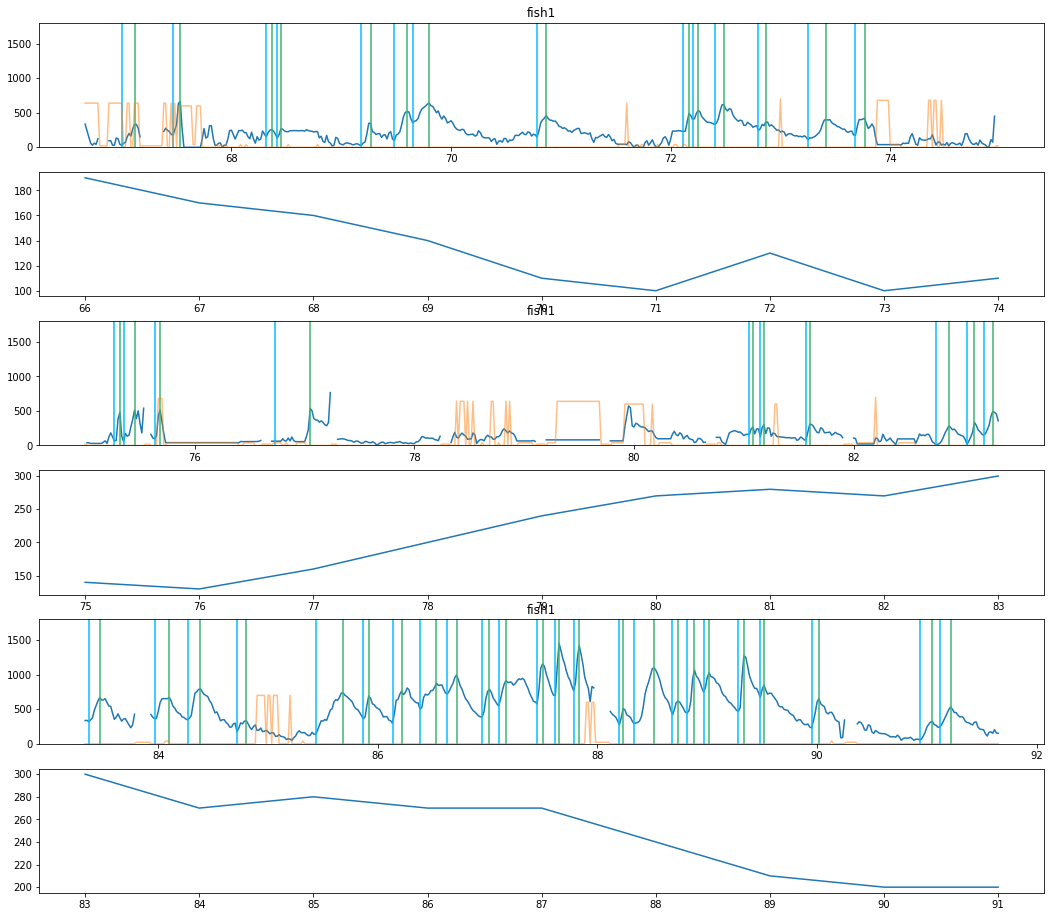

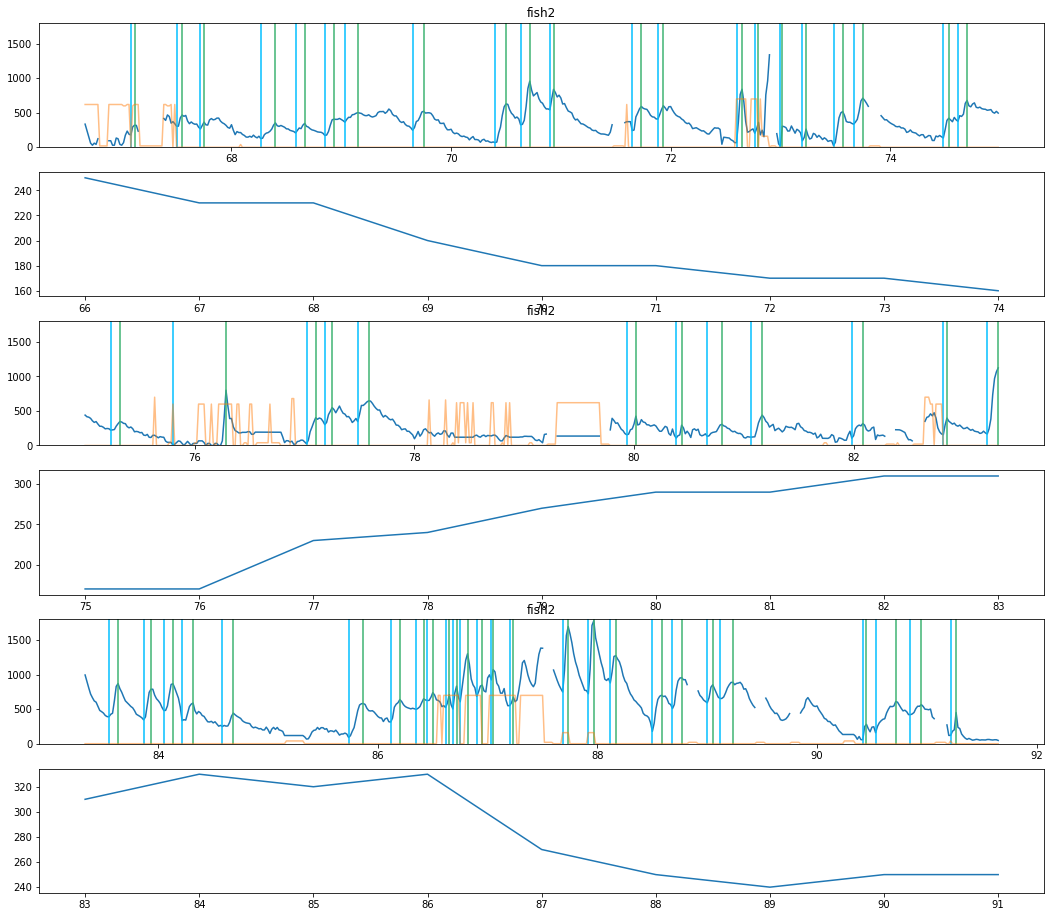

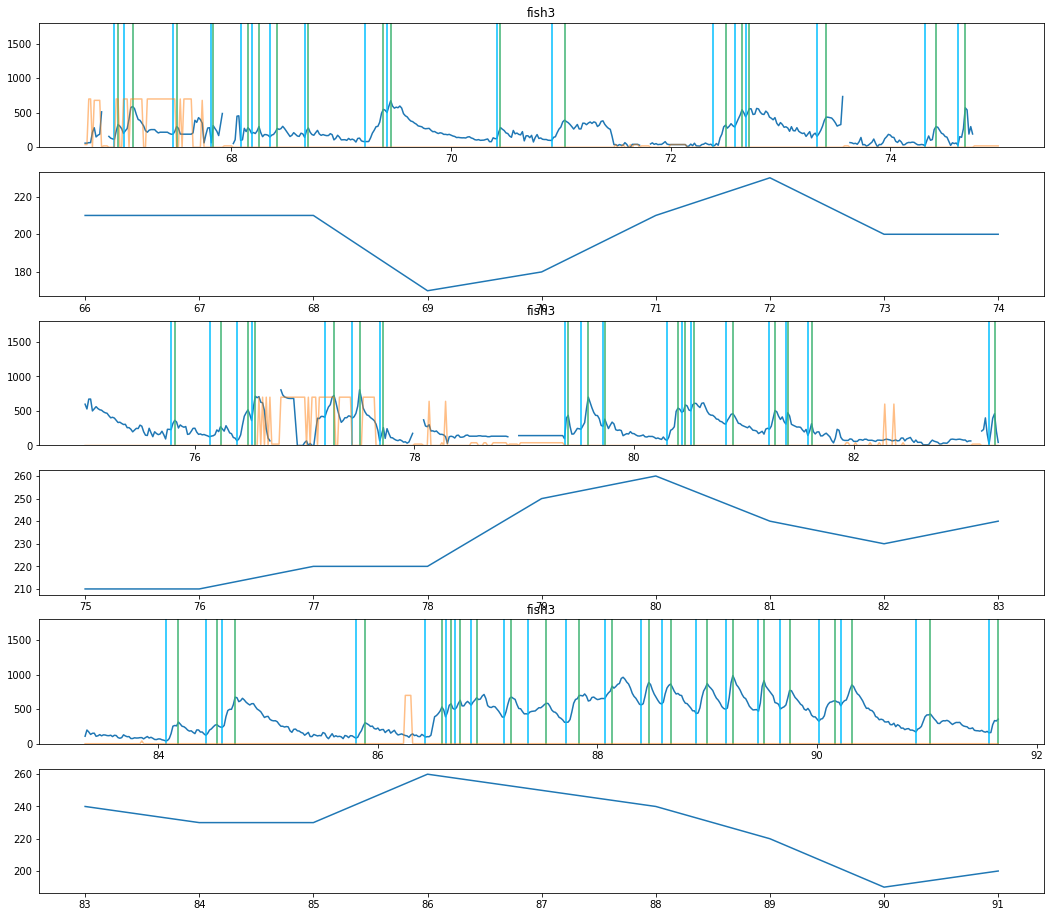

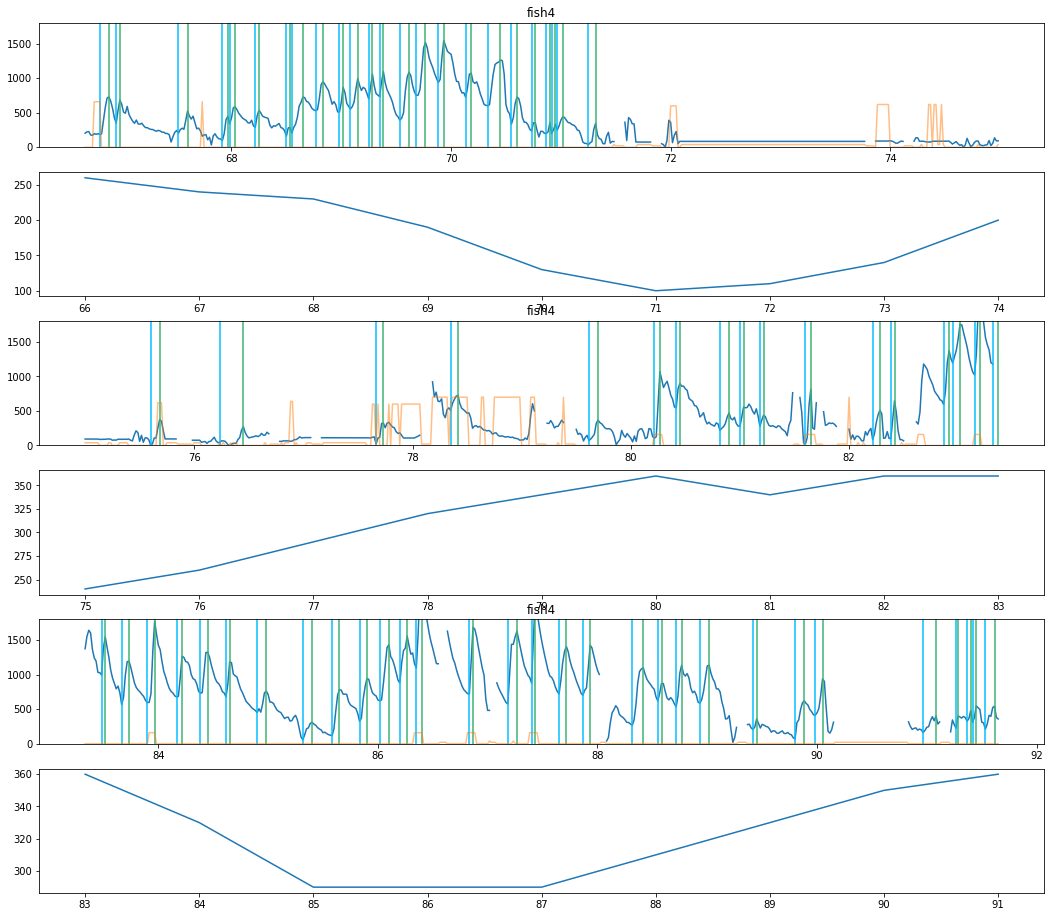

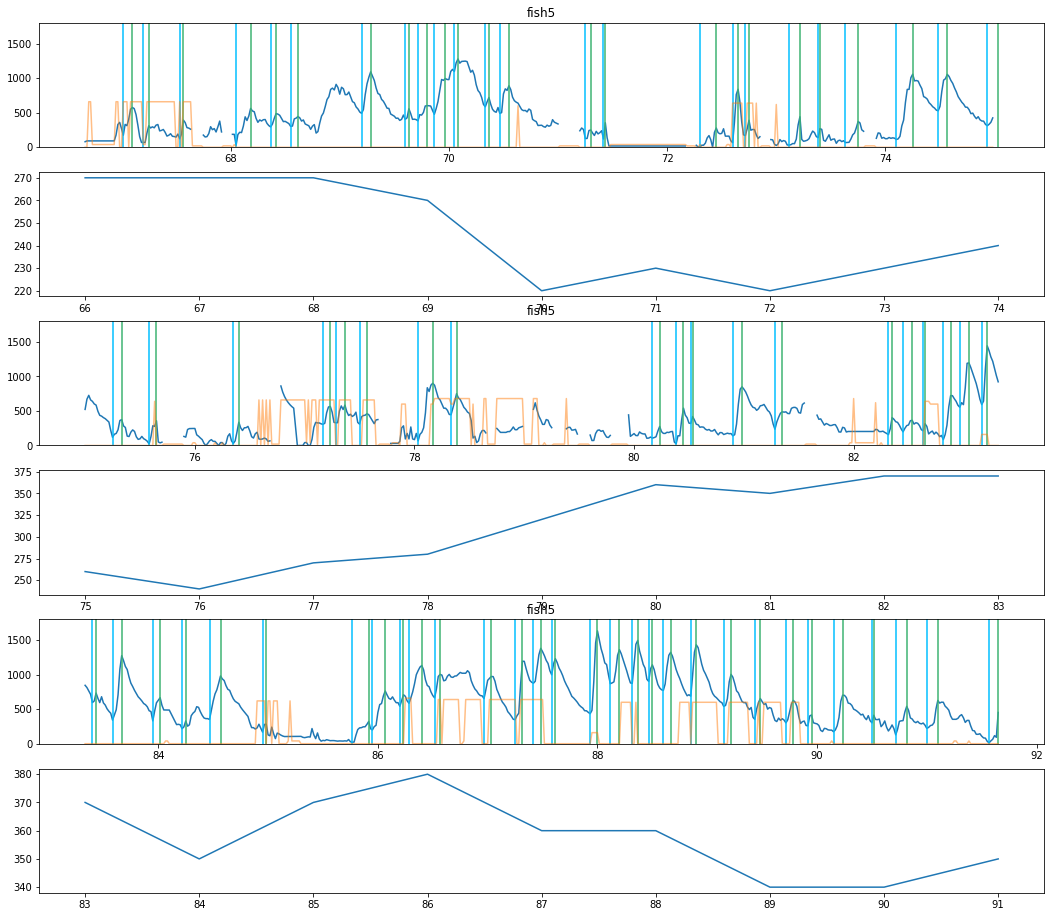

In [95]:
# example speed trajectories with burst detection & errors
for i in fishIncl:
    
    fishname = fishnames[fishIncl[i]]
    burstmat = burstsAll.loc[fishname].copy()
    burstrate = bRateAll.loc[fishname].copy()
    burstrate.set_index('tstart',inplace=True)

    nplots = 3
    f0, axs = plt.subplots(nplots*2,1, figsize=(18,16))
    timestart = 4000
    twinsize = 500 #
    twinstarts = np.arange(timestart, timestart + twinsize*nplots,twinsize) 

    for jj in range(nplots):
        j = 2*jj
        q = 2*jj+1
        twinstart = twinstarts[jj]
        twinend = twinstart+twinsize
        ind = np.arange(twinstart,twinsize+twinstart)
        
        #example speed trajectories
        axs[j].plot(time[ind], speeds[ind,i])
        axs[j].set_title(fishname)
        axs[j].set_ylim([0,1800])
        bstart = burstmat.loc[(burstmat['valleyTime'] > time[twinstart]) & (burstmat['valleyTime'] < time[twinend]),['valleyTime']].values
        bpeak = burstmat.loc[(burstmat['valleyTime'] > time[twinstart]) & (burstmat['valleyTime'] < time[twinend]),['peakTime']].values
        bb = np.hstack([bstart,bpeak])
        
        #plot burst valleys and peaks as vertical lines
        for xc in bb:
            axs[j].axvline(x = xc[0],color='deepskyblue')
            axs[j].axvline(x = xc[1],color='mediumseagreen')
        
        #errors
        errs = errType.loc[ind,fishname]
        axs[j].plot(time[ind],errs*20,alpha = 0.5)
        
        #plot burstrate below each speed window
        tstart = np.floor(np.min(time[ind]))
        tend = np.floor(np.max(time[ind]))
        axs[q].plot(burstrate.burstrate[tstart:tend]*100)
    
        

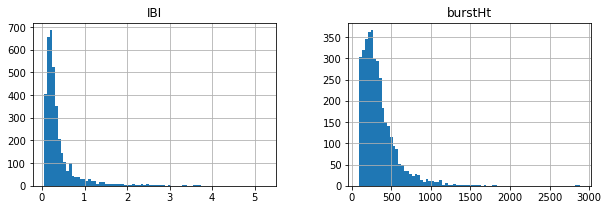

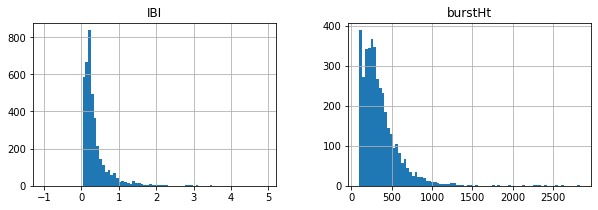

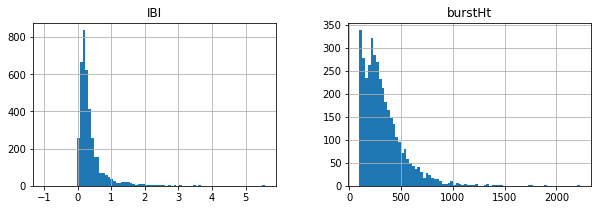

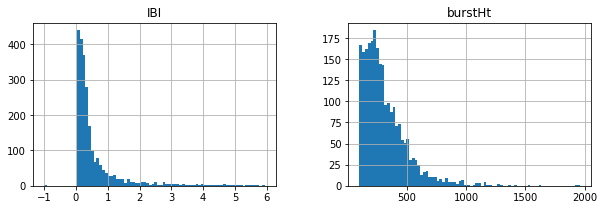

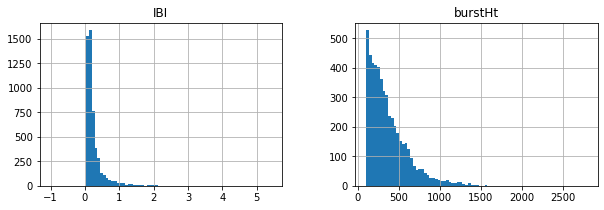

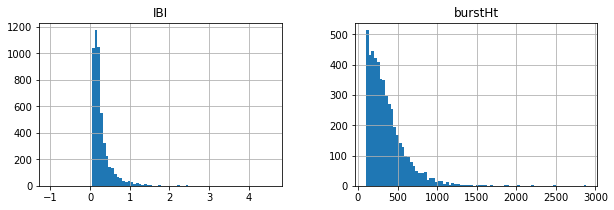

In [108]:
# histograms: burst height distribution, IBI distribution
for i in fishIncl:  
    fishname = fishnames[fishIncl[i]]
    burstmat = burstsAll.loc[fishname].copy()
    burstmat = burstmat.loc[(burstmat['burstHt']<3000) & (burstmat['IBI'] < 6)]
    
    burstmat[['burstHt',"IBI"]].hist(bins = 80, figsize = (10,3))



In [70]:

# possibly: example fits, burst distributions with add'l filters

In [ ]:
# maybe: kernel or wavelet smooth; don't want to do for now (I think burst coordination analysis may be better w/o it) but consider for later